In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import scipy.io.wavfile as wav
import os
import pandas as pd
import matplotlib.pyplot as plt
import torchaudio
import glob
import math
import torch.nn as nn
import numpy as np
from bisect import bisect_left
import scipy as sp
import h5py


In [2]:
data_folder = "../datasets/generated_dataset/"
device = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
dropout = 0.1
batch_size = 512
fs = 16000


f = h5py.File("../datasets/generated_dataset/generated_dataset.hdf5","r")
f_test = h5py.File("../datasets/generated_dataset/generated_dataset_val.hdf5","r")

X = f['input']
y = f['gt']
X_test = f_test['input']
y_test = f_test['gt']

#X = torch.load(os.path.join(data_folder,"input2.pt"))
#y = torch.load(os.path.join(data_folder,"gt2.pt"))
#X_test = torch.load(os.path.join(data_folder,"input.pt"))
#y_test = torch.load(os.path.join(data_folder,"gt.pt"))

class custom_dataset(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __getitem__(self, idx):
        return self.X[idx],self.y[idx]

    def __len__(self):
        return len(self.X)

dataset = custom_dataset(X,y)
dataset_test = custom_dataset(X_test,y_test)
train_dl = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)


In [3]:

cnn_output_size_at_factor_1 = 576
factor = 2
class Block(nn.Module):
    def __init__(self,size):
        super().__init__()
        self.l = nn.Linear(size,size)
        self.act = nn.GELU()
        #self.ln = nn.LayerNorm(size)
    
    def forward(self, x):
        return x + self.act(self.l(x))

class Classifier(nn.Module):

    def __init__(self):
        super().__init__()
        #self.ln1 = nn.LayerNorm(6250)
        #self.ln2 = nn.LayerNorm(2016)
        
        self.thinker = nn.Sequential(
            nn.Dropout(dropout),
            Block(cnn_output_size_at_factor_1*factor),
            Block(cnn_output_size_at_factor_1*factor),
            Block(cnn_output_size_at_factor_1*factor),
        )
        self.apply(self._init_weights)

        self.cnn = nn.Sequential(
            nn.Conv1d(4,16*factor, 50,stride=5),
            nn.GELU(),
            nn.Conv1d(16*factor,32*factor, 50,stride=5),
            nn.GELU(),
            nn.Conv1d(32*factor,48*factor, 30,stride=5),
            nn.GELU(),
            nn.Flatten(),
        )
        self.compress = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(cnn_output_size_at_factor_1*factor, 10*factor),
            nn.GELU(),
            nn.Linear(10*factor, 1),
        )
        
        
        
        

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        
                
    def forward(self, x):
        x = self.cnn(x)
        
        x = self.thinker(x)
        return self.compress(x)
    
model = Classifier().to(device)

In [8]:
loss_fn = torch.nn.MSELoss()
#loss_fn = torch.nn.HuberLoss(delta=10)

def train(dataloader, model, loss_fn, optimizer):
    save_loss_to_file = []
    size = len(dataloader.dataset)
    model.train()
    
    n_batch_before_print = 100
    print_loss = 0
    for batch, (X,y) in enumerate(dataloader):
        
        # Compute prediction error
        X = torch.concatenate([X[:,:,:,0], X[:,:,:,1]], dim=1)
        X /= 1e6
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        

        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print_loss += loss.detach()/n_batch_before_print
        if batch % n_batch_before_print == 0 and batch != 0:
            loss, current = print_loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            print_loss = 0
            save_loss_to_file.append((loss, current))
    return save_loss_to_file

def test(dataloader, model, loss_fn):
    model.eval()
    with torch.no_grad():
        print_loss = 0
        for batch, (X,y) in enumerate(dataloader):
            
            # Compute prediction error
            X = torch.concatenate([X[:,:,:,0], X[:,:,:,1]], dim=1)
            X /= 1e6
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            

            loss = loss_fn(pred, y)        
            print_loss += loss.detach()

        loss = print_loss.item()/len(dataloader)
        print(f"Test loss: {loss:>7f}")
        print_loss = 0
        

In [10]:
epochs = 500

schedule_steps = 0
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=10)
for t in range(epochs):
    losses = np.zeros((0,2))
    print(f"Epoch {t+1}\n-------------------------------")
    #torch.save(model, "model_musan_epoch_" + str(t)+ ".pth")

    loss_to_file = test(test_dl, model, loss_fn)
    loss_to_file = train(train_dl, model, loss_fn, optimizer)
 #   if t < schedule_steps:
 #       scheduler.step()
    
    #losses = np.concatenate([losses,np.array(loss_to_file
    # )])
    #np.save("losses", losses)
print("Done!")

Epoch 1
-------------------------------
Test loss: 4816.484375
loss: 2655.358887  [51200/500000]
loss: 2600.833008  [102400/500000]
loss: 2568.262207  [153600/500000]
loss: 2617.191406  [204800/500000]
loss: 2623.901611  [256000/500000]


KeyboardInterrupt: 

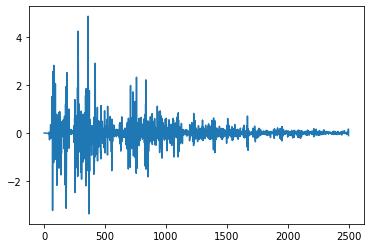

In [ ]:
plt.plot(dataset[0][0][1,:,0]/1e6)
#next(iter(train_dl))[0]